<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.6 Car Example](https://ndcbe.github.io/CBE60499/02.06-Pyomo-DAE.html) | [Contents](toc.html) | [2.7 Stochastic Programming](https://ndcbe.github.io/CBE60499/02.07-SP.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.06-Reaction-DAE-Simulator-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.06-Reaction-DAE-Simulator-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.6 Reaction Kinetics Example / Simulation with Pyomo.DAE
**Lecture 20**. Nonlinear and Stochastic Optimization. CBE 60499. A. Dowling. Fall 2018.

Adapted from: https://github.com/Pyomo/pyomo/blob/master/examples/dae/simulator_dae_example.py

## 2.6.1 Problem Formulation

Consider the chemical reaction $$A \Leftrightarrow B \Leftrightarrow C$$

which is modeling with the following differential algebraic equations:

$$\begin{align*}
\frac{dz_A}{dt} &= -p_1 z_A(t) + p_2 z_B(t),\quad z_A(0)=1 \\
\frac{dz_B}{dt} &= p_1 z_A(t) - (p_2 + p_3) z_B(t) + p_4 z_C(t), \quad z_B(0)=0 \\
1 &= z_A(t) + z_B(t) + z_C(t)
\end{align*}$$

where $p_1$, $p_2$, $p_3$, and $p_4$ are parameters.

## 2.6.2 Create Model

In [1]:
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator
import matplotlib.pyplot as plt

def create_model():
    m = ConcreteModel()

    m.t = ContinuousSet(bounds=(0.0, 1))

    m.p1 = Param(initialize=4.0)
    m.p2 = Param(initialize=2.0)
    m.p3 = Param(initialize=40.0)
    m.p4 = Param(initialize=20.0)

    m.za = Var(m.t)
    m.zb = Var(m.t)
    m.zc = Var(m.t)
    m.dza = DerivativeVar(m.za)
    m.dzb = DerivativeVar(m.zb)

    # Setting the initial conditions
    m.za[0.0] = 1
    m.zb[0.0] = 0

    def _diffeq1(m, t):
        return m.dza[t] == -m.p1 * m.za[t] + m.p2 * m.zb[t]
    m.diffeq1 = Constraint(m.t, rule=_diffeq1)

    def _diffeq2(m, t):
        return m.dzb[t] == m.p1 * m.za[t] - \
                           (m.p2 + m.p3) * m.zb[t] + m.p4 * m.zc[t]
    m.diffeq2 = Constraint(m.t, rule=_diffeq2)

    def _algeq1(m, t):
        return m.za[t] + m.zb[t] + m.zc[t] == 1
    m.algeq1 = Constraint(m.t, rule=_algeq1)
    return m

## 2.6.3 Simulate Model

In [2]:
def simulate_discretize_model(m,NFE,initialize):
    # Simulate the model using casadi
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator='idas')

    # Discretize model using Orthogonal Collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=NFE, ncp=3)

    if initialize:
    # Initialize the discretized model using the simulator profiles
        sim.initialize_model()
    
    return sim, tsim, profiles

## 2.6.4 Plot Results

In [3]:
def plot_result(m, sim, tsim, profiles,initialize):

    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    for idx1, v in enumerate(varorder):
        plt.plot(tsim, profiles[:, idx1], label=v)

    for idx2, v in enumerate(algorder):
        plt.plot(tsim, profiles[:, len(varorder) + idx2], label=v)

    if initialize:
        time = list(m.t)
        za = [value(m.za[t]) for t in m.t]
        zb = [value(m.zb[t]) for t in m.t]
        zc = [value(m.zc[t]) for t in m.t]
        
        plt.plot(time, za, 'o', label='za interp')
        plt.plot(time, zb, 'o', label='zb interp')
        plt.plot(time, zc, 'o', label='zc interp')
    
    plt.xlabel('t')
    plt.legend(loc='best')
    plt.show()

## 2.6.5 Main Routine

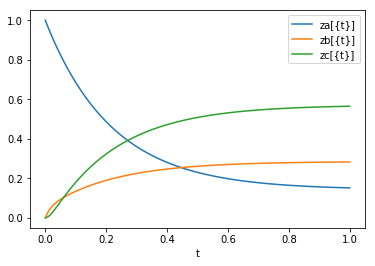

In [4]:
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False

# Number of finite elements
NFE = 6

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Plot simulation results
plot_result(model, sim, tsim, profiles,init)

## 2.6.6 Solve Collocation Formulation

In [5]:
# Specify initial conditions
def _init(m):
    yield m.za[0] == 1
    yield m.zb[0] == 0
model.initcon = ConstraintList(rule=_init)

# Solve collocation formulation (no objective)
solver = SolverFactory('ipopt')
solver.solve(model,tee=True)

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      372
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       95
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 95, 'Number of variables': 95, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.10\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.04537773132324219}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

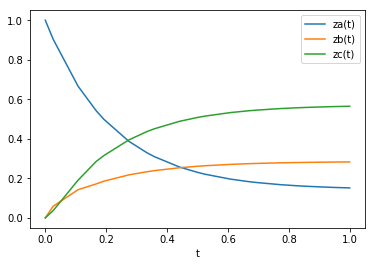

In [6]:
def plot_results2(m):
    za = []
    zb = []
    zc = []
    time = []
    for t in m.t:
        time.append(value(t))
        za.append(value(m.za[t]))
        zb.append(value(m.zb[t]))
        zc.append(value(m.zc[t]))

    plt.plot(time, za, '-', label='za(t)')
    plt.plot(time, zb, '-', label='zb(t)')
    plt.plot(time, zc, '-', label='zc(t)')
    plt.xlabel('t')
    plt.legend(loc='best')
    plt.show()
    
plot_results2(model)

## 2.6.7 Discussion
* What happens if we disable initialization?
* How does the problem size and solution profiles change with the number of finite elements?
* How many degrees of freedom are there in the *simulation* problem?
* Why is this problem robust to poor initialization?

<!--NAVIGATION-->
< [2.6 Car Example](https://ndcbe.github.io/CBE60499/02.06-Pyomo-DAE.html) | [Contents](toc.html) | [2.7 Stochastic Programming](https://ndcbe.github.io/CBE60499/02.07-SP.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.06-Reaction-DAE-Simulator-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.06-Reaction-DAE-Simulator-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>